In [1]:
from keras import backend as K
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Convolution2D, ZeroPadding2D, BatchNormalization, Add
from keras.layers.core import Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from google.colab import drive

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [0]:
import uresnet34

In [11]:
uresnet34.uresnet

<function uresnet34.uresnet>

In [8]:
os.listdir("./drive/My Drive/Rosneft Seismic")

['local2.bat',
 'new_sub.csv',
 'utils.py',
 'trainset.sgy',
 'trainset_mask.sgy',
 '.ipynb_checkpoints',
 'prepare_data.ipynb',
 'baseline.ipynb',
 '__pycache__',
 'train',
 'test',
 'csv_to_pic.ipynb',
 'csv_to_pic_color.ipynb',
 'dice_metric.py',
 'uresnet34.py',
 'human+unet+resnet.ipynb',
 'human+unet+resnet_v3.ipynb',
 'people',
 'human+unet+resnet_rus.ipynb',
 'uresnet34_v2.py',
 'human+unet+resnet_v4.ipynb',
 'models',
 'Untitled.ipynb']

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def Conv2D_34skipblock(filters, strides=(3, 3), activation="relu", padding="same"):
    assert(isinstance(strides, tuple))
    assert(2 == len(strides))

    def f(x):
        conv1 = Conv2D(filters, strides, padding=padding)(x)
        batch_norm1 = BatchNormalization()(conv1)
        act1 = Activation(activation=activation)(batch_norm1)
        conv2 = Conv2D(filters, strides, padding=padding)(act1)
        batch_norm2 = BatchNormalization()(conv2)
        act2 = Activation(activation=activation)(batch_norm2)
        add = Add()([x, act2])
        return add
    return f

def uresnet(image_rows, image_cols, skip_block, img_channels=1):

    inputs = Input((image_rows, image_cols, img_channels))
    conv0 = Conv2D(32, (3, 3), padding='same')(inputs)
    batch_norm0 = BatchNormalization()(conv0)
    act0 = Activation(activation='relu')(batch_norm0)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(act0)
    conv1 = skip_block(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = skip_block(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = skip_block(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = skip_block(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = skip_block(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = skip_block(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = skip_block(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = skip_block(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = skip_block(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = skip_block(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = skip_block(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = skip_block(256, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = skip_block(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = skip_block(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = skip_block(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = skip_block(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = skip_block(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = skip_block(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [0]:
K.set_image_data_format('channels_last')

NB_EPOCH = 50
BATCH_SIZE = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIMIZER = Adam(lr=1e-5)
IMG_ROWS, IMG_COLS, IMG_CHANNELS = 320, 240, 1

Train = 1315
Valid = 145

x_train = []
y_train = []

x_valid = []
y_valid = []

people_path = "./drive/My Drive/Rosneft Seismic/people"

In [0]:
print('LOAD TRAIN DATA')
for i in tqdm(range(Train)):
    x_train.append(
        np.array(
            Image.open(f"{people_path}/train/{str(i)}.jpg")
        ).dot([0.299, 0.587, 0.114])
    )
    y_train.append(
        np.array(Image.open(f"{people_path}/train_mask/{str(i)}.png"))
    )
print('END LOAD TRAIN DATA') 

print('LOAD VALID DATA')
for i in tqdm(range(Valid)):
    x_valid.append(
        np.array(
            Image.open(f"{people_path}/valid/{str(1315 + i)}.jpg")
        ).dot([0.299, 0.587, 0.114])
    )
    y_valid.append(
        np.array(Image.open(f"{people_path}/valid_mask/{str(1315 + i)}.png"))
    )
print('END LOAD VALID DATA')

print('START PREPROCESSING')
x_train = np.array(x_train)
x_train = x_train.astype('float32')
x_train -= x_train.mean()
x_train /= x_train.std()
x_train = x_train[:, :, :, np.newaxis]

x_valid = np.array(x_valid)
x_valid = x_valid.astype('float32')
x_valid -= x_valid.mean()
x_valid /= x_valid.std()
x_valid = x_valid[:, :, :, np.newaxis]

y_train = np.array(y_train)
y_train = y_train.astype('float32')
y_train /= 255
y_train = y_train[:, :, :, np.newaxis]

y_valid = np.array(y_valid)
y_valid = y_valid.astype('float32')
y_valid /= 255
y_valid = y_valid[:, :, :, np.newaxis]
print('END PREPROCESSING')

  5%|▍         | 62/1315 [00:00<00:02, 613.26it/s]

LOAD TRAIN DATA


 41%|████      | 59/145 [00:00<00:00, 585.35it/s]

END LOAD TRAIN DATA
LOAD VALID DATA


100%|██████████| 145/145 [00:00<00:00, 605.13it/s]


END LOAD VALID DATA
START PREPROCESSING
END PREPROCESSING


In [0]:
#np.save(f"{people_path}/x_train.npy", x_train)
x_train = np.load(f"{people_path}/x_train.npy")

#np.save(f"{people_path}/y_train.npy", y_train)
y_train = np.load(f"{people_path}/y_train.npy")

#np.save(f"{people_path}/x_valid.npy", x_valid)
x_valid = np.load(f"{people_path}/x_valid.npy")

#np.save(f"{people_path}/y_valid.npy", y_valid)
y_valid = np.load(f"{people_path}/y_valid.npy")

In [0]:
model = uresnet(IMG_ROWS, IMG_COLS, Conv2D_34skipblock, IMG_CHANNELS)
model.compile(optimizer=OPTIMIZER, loss=dice_coef_loss, metrics=[dice_coef])

model_checkpoint = ModelCheckpoint("people_weights.h5", monitor="val_loss", save_best_only=True)

In [0]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE,
                    shuffle=True, validation_split=VALIDATION_SPLIT, callbacks=[model_checkpoint])



Train on 1052 samples, validate on 263 samples
Epoch 1/50
1052/1052 [==============================] - 211s 201ms/step - loss: -0.7562 - dice_coef: 0.7562 - val_loss: -0.8485 - val_dice_coef: 0.8485
Epoch 2/50
1052/1052 [==============================] - 190s 181ms/step - loss: -0.8534 - dice_coef: 0.8534 - val_loss: -0.8503 - val_dice_coef: 0.8503
Epoch 3/50
1052/1052 [==============================] - 190s 180ms/step - loss: -0.8693 - dice_coef: 0.8693 - val_loss: -0.8697 - val_dice_coef: 0.8697
Epoch 4/50
1052/1052 [==============================] - 190s 181ms/step - loss: -0.8767 - dice_coef: 0.8767 - val_loss: -0.8815 - val_dice_coef: 0.8815
Epoch 5/50
1052/1052 [==============================] - 190s 181ms/step - loss: -0.8880 - dice_coef: 0.8880 - val_loss: -0.8273 - val_dice_coef: 0.8273
Epoch 6/50
1052/1052 [==============================] - 190s 181ms/step - loss: -0.8925 - dice_coef: 0.8925 - val_loss: -0.8996 - val_dice_coef: 0.8996
Epoch 7/50
1052/1052 [=================

In [0]:
score = model.evaluate(x_valid, y_valid, batch_size=BATCH_SIZE, verbose=VERBOSE)
print(score)

145/145 [==============================] - 9s 59ms/step
[-0.9275758636408838, 0.9275758636408838]


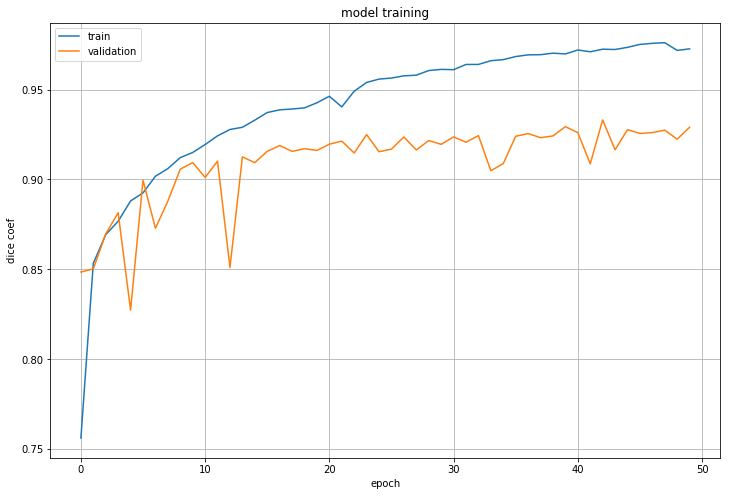

In [0]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["dice_coef"])
plt.plot(history.history["val_dice_coef"])
plt.title('model training')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.savefig(f"{people_path}/people_model.png")
plt.show()